<a href="https://colab.research.google.com/github/mfz/fastbook/blob/master/My_PET_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
! curl -s https://course.fast.ai/setup/colab | bash
! pip install fastai2
! pip install nbdev
! pip install azure-cognitiveservices-search-imagesearch

In [0]:
from fastai2.vision.all import *
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype

import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
mpl.rcParams['savefig.dpi']= 200
mpl.rcParams['font.size']=12

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.set_option('display.max_columns',999)
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

matplotlib.rc('image', cmap='Greys')

## PET data set

Check out how data is organized.

root/images/breed_num.jpg, but breed can contain underscores as well

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_116.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_45.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_90.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_70.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_184.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_138.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_76.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_128.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_130.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_120.jpg')...]

In [0]:
fname = (path/"images").ls()[0]

In [7]:
fname.name

'shiba_inu_116.jpg'

In [8]:
re.findall(r'(.+)_\d+\.jpg$', fname.name)

['shiba_inu']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

pets.summary(path/"images")


Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_105.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_105.jpg
    applying partial gives
      great_pyrenees
    applying Categorize gives
      TensorCategory(21)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(21))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB siz

In [0]:
dls = pets.dataloaders(path/"images")


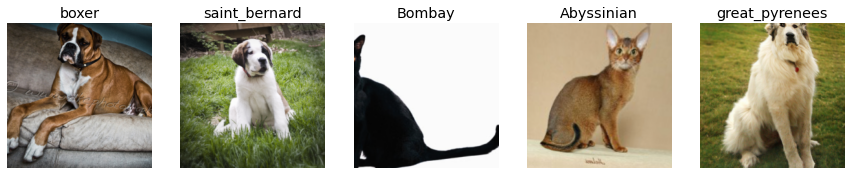

In [11]:
dls.show_batch(nrows=1, ncols=5)

Let's train an off-the-shelf model on this data set and see how good it is.

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.521953,0.421643,0.129229,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.503492,0.309712,0.096076,01:14
1,0.316073,0.246735,0.072395,01:15


fastai automatically chooses crossentropy loss for image model with categories

$\mathrm{crossentropy} = - \sum_c y_c \log p_c$

where $y_c$ is one-hot-encoded category.

To convert activation $a_c$ to probability $p_c$, softmax function is used

$\mathrm{softmax}(x_k) = \frac{\exp(x_k)}{\sum_j \exp(x_j)}$


## Learning rate

Most important for proper training of the NN is the learning rate.
Too large learning rate leads to oscillations, too small a learning rate requires many epochs (and can thus lead to overfitting).

fastai provides learning rate finder

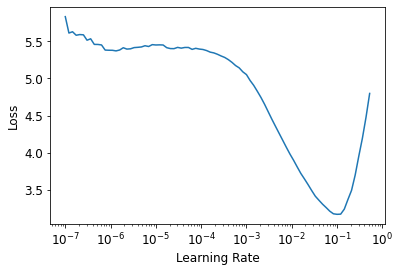

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

the returned lr_min is actually lr_min/10

In [14]:
lr_min, lr_steep

(0.010000000149011612, 0.002511886414140463)

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr = 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.287249,0.351879,0.111637,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.529512,0.413728,0.118403,01:17
1,0.306913,0.300961,0.081867,01:16


## Manual fine tuning

fastai freezes all but last layer when using a pretrained model.

Can either use 

```
learn.fine_tune(epochs, base_lr = lr)
```

or do steps manually:



```
learn.fit_one_cycle(epochs, lr)
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(epochs, lr)
```




In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.139612,0.392301,0.122463,01:13
1,0.546256,0.289083,0.088633,01:13
2,0.340511,0.245473,0.074425,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.257794,0.242850,0.073072,01:15
1,0.247474,0.231093,0.068336,01:15
2,0.231692,0.236052,0.071042,01:15
3,0.218811,0.234167,0.073748,01:15
4,0.187499,0.225897,0.070365,01:15
5,0.169990,0.214690,0.068336,01:15
6,0.166562,0.222420,0.064953,01:16
7,0.141888,0.220333,0.069689,01:15
8,0.138338,0.216625,0.069012,01:15
9,0.131827,0.209185,0.066982,01:15


## Deeper architectures

can try Resnet50 as well, to check for improvement.
But deeper architectures are not always better, might also overfit.